# Mixed Effects Regressions - TEMPLATE
Created: 07/30/24 \
Updated: 07/31/2024 \

*Run for NYC Neuromod Conf

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08012024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [9]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




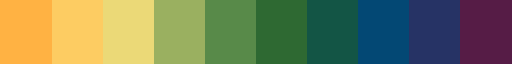

In [10]:
#### set theme for all plots

sns.set_theme(style='ticks') 
sns.set_context("poster")
# saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
saez_hex_cmap  = ListedColormap(saez_colors)
saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]
saez_full_cmap


In [11]:
expanded_cmap

['#ffb243',
 '#fdcd63',
 '#ecda77',
 '#9bb060',
 '#598a49',
 '#2e6a33',
 '#135546',
 '#034975',
 '#263365',
 '#561c46']

# Set FOI - FREQUENCY OF INTEREST & load data

In [12]:
FOI = 'beta'

band_pow_df = pd.read_csv(f'{save_dir}{FOI}_master_df.csv')
band_pow_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [13]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
stg              105
vlpfc             82
ains              71
smg               66
pins              60
thalamus          58
mtg               57
temporal pole     31
mcc               28
motor             25
phg               25
parietal          24
vmpfc             23
fusiform          19
occipital         19
itg               15
angular           14
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [14]:
#### filter df by rois with electrode counts >= 50 *** updated to >15
keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
).values>=20].tolist()


In [15]:
band_reg_df = band_pow_df.copy()
band_reg_df = band_reg_df[band_reg_df.roi.isin(keep_rois)]


# Run All Electrode Regressions First 
- use to pick best covariates - see old code for this. for now using same covariates as behavior data

In [16]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

In [17]:
final_vars   = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE']
final_fit = fit_mixed_model(band_reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic  

                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          band_pow  
No. Observations:            244112           Method:                      ML        
No. Groups:                  1776             Scale:                       0.0408    
Min. group size:             65               Log-Likelihood:              39057.2397
Max. group size:             148              Converged:                   Yes       
Mean group size:             137.5                                                   
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.053    0.003 -20.559 0.000 -0.058 -0.048
C(GambleChoice)[T.safe]                   -0.006    0.001  -4.528 0.000 -0.009

-77928.39857466736

In [18]:
mixed_effects_ftest_ttest(final_fit)

(        coef   std err         t         P>|t|  Conf. Int. Low  \
 c0 -0.006415  0.001417 -4.528324  5.948156e-06       -0.009192   
 c1  0.005538  0.001216  4.552795  5.296325e-06        0.003154   
 c2  0.005382  0.000926  5.810197  6.247649e-09        0.003566   
 
     Conf. Int. Upp.  
 c0        -0.003639  
 c1         0.007921  
 c2         0.007197  ,
 <class 'statsmodels.stats.contrast.ContrastResults'>
 <F test: F=114.84650492902607, p=1.30842194455695e-310, df_denom=2.44e+05, df_num=13>)

In [19]:
final_fit.pvalues['decisionCPE']

6.2399362421531764e-09

In [20]:
fe_params = final_fit.params
fe_params

Intercept                                   -0.052732
C(GambleChoice)[T.safe]                     -0.006415
TotalProfit                                  0.005538
decisionCPE                                  0.005382
Group Var                                    0.270554
Group x C(GambleChoice)[T.safe] Cov         -0.024023
C(GambleChoice)[T.safe] Var                  0.054154
Group x TotalProfit Cov                     -0.013227
C(GambleChoice)[T.safe] x TotalProfit Cov    0.003020
TotalProfit Var                              0.034491
Group x decisionCPE Cov                      0.007314
C(GambleChoice)[T.safe] x decisionCPE Cov   -0.008769
TotalProfit x decisionCPE Cov                0.002765
decisionCPE Var                              0.007826
dtype: float64

In [21]:
model_results = mixed_eff_results_df(final_fit,band_reg_df)
model_results

,unique_reref_ch,subj_id,roi,bdi,raw_Intercept,raw_GambleChoice,raw_TotalProfit,raw_decisionCPE,Intercept,GambleChoice,TotalProfit,decisionCPE
0,DA023_lac1-lac2,DA023,acc,14,0.057361,-0.029050,-0.021459,0.009745,0.004629,-0.035465,-0.015921,0.015127
1,DA023_lac10-lac11,DA023,dmpfc,14,0.053941,-0.016110,0.038571,0.000143,0.001209,-0.022525,0.044109,0.005524
2,DA023_lac2-lac3,DA023,acc,14,0.059621,-0.008149,0.010839,-0.000613,0.006889,-0.014564,0.016376,0.004769
3,DA023_lac3-lac4,DA023,acc,14,0.057437,-0.006519,-0.000856,0.000687,0.004705,-0.012935,0.004682,0.006069
4,DA023_lac4-lac5,DA023,dmpfc,14,0.076148,-0.040695,0.010018,0.004794,0.023417,-0.047110,0.015556,0.010175
...,...,...,...,...,...,...,...,...,...,...,...,...
1771,MS050_rmoif4-rmoif5,MS050,ofc,9,0.027983,0.045404,0.024945,-0.005359,-0.024749,0.038989,0.030483,0.000023
1772,MS050_rmoif5-rmoif6,MS050,ofc,9,0.043654,0.045465,0.003638,0.002163,-0.009077,0.039049,0.009176,0.007545
1773,MS050_rmoif6-rmoif7,MS050,ofc,9,0.057970,0.030775,0.003308,0.003615,0.005238,0.024360,0.008846,0.008996
1774,MS050_rmoif7-rmoif8,MS050,ofc,9,0.065559,-0.001522,-0.012406,0.030369,0.012827,-0.007938,-0.006868,0.035751


In [22]:
# Plot Data 

In [23]:
bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy','motor']
# roi_order = ['dlpfc','vlpfc','ofc','ains','pins','acc','hpc','amy']

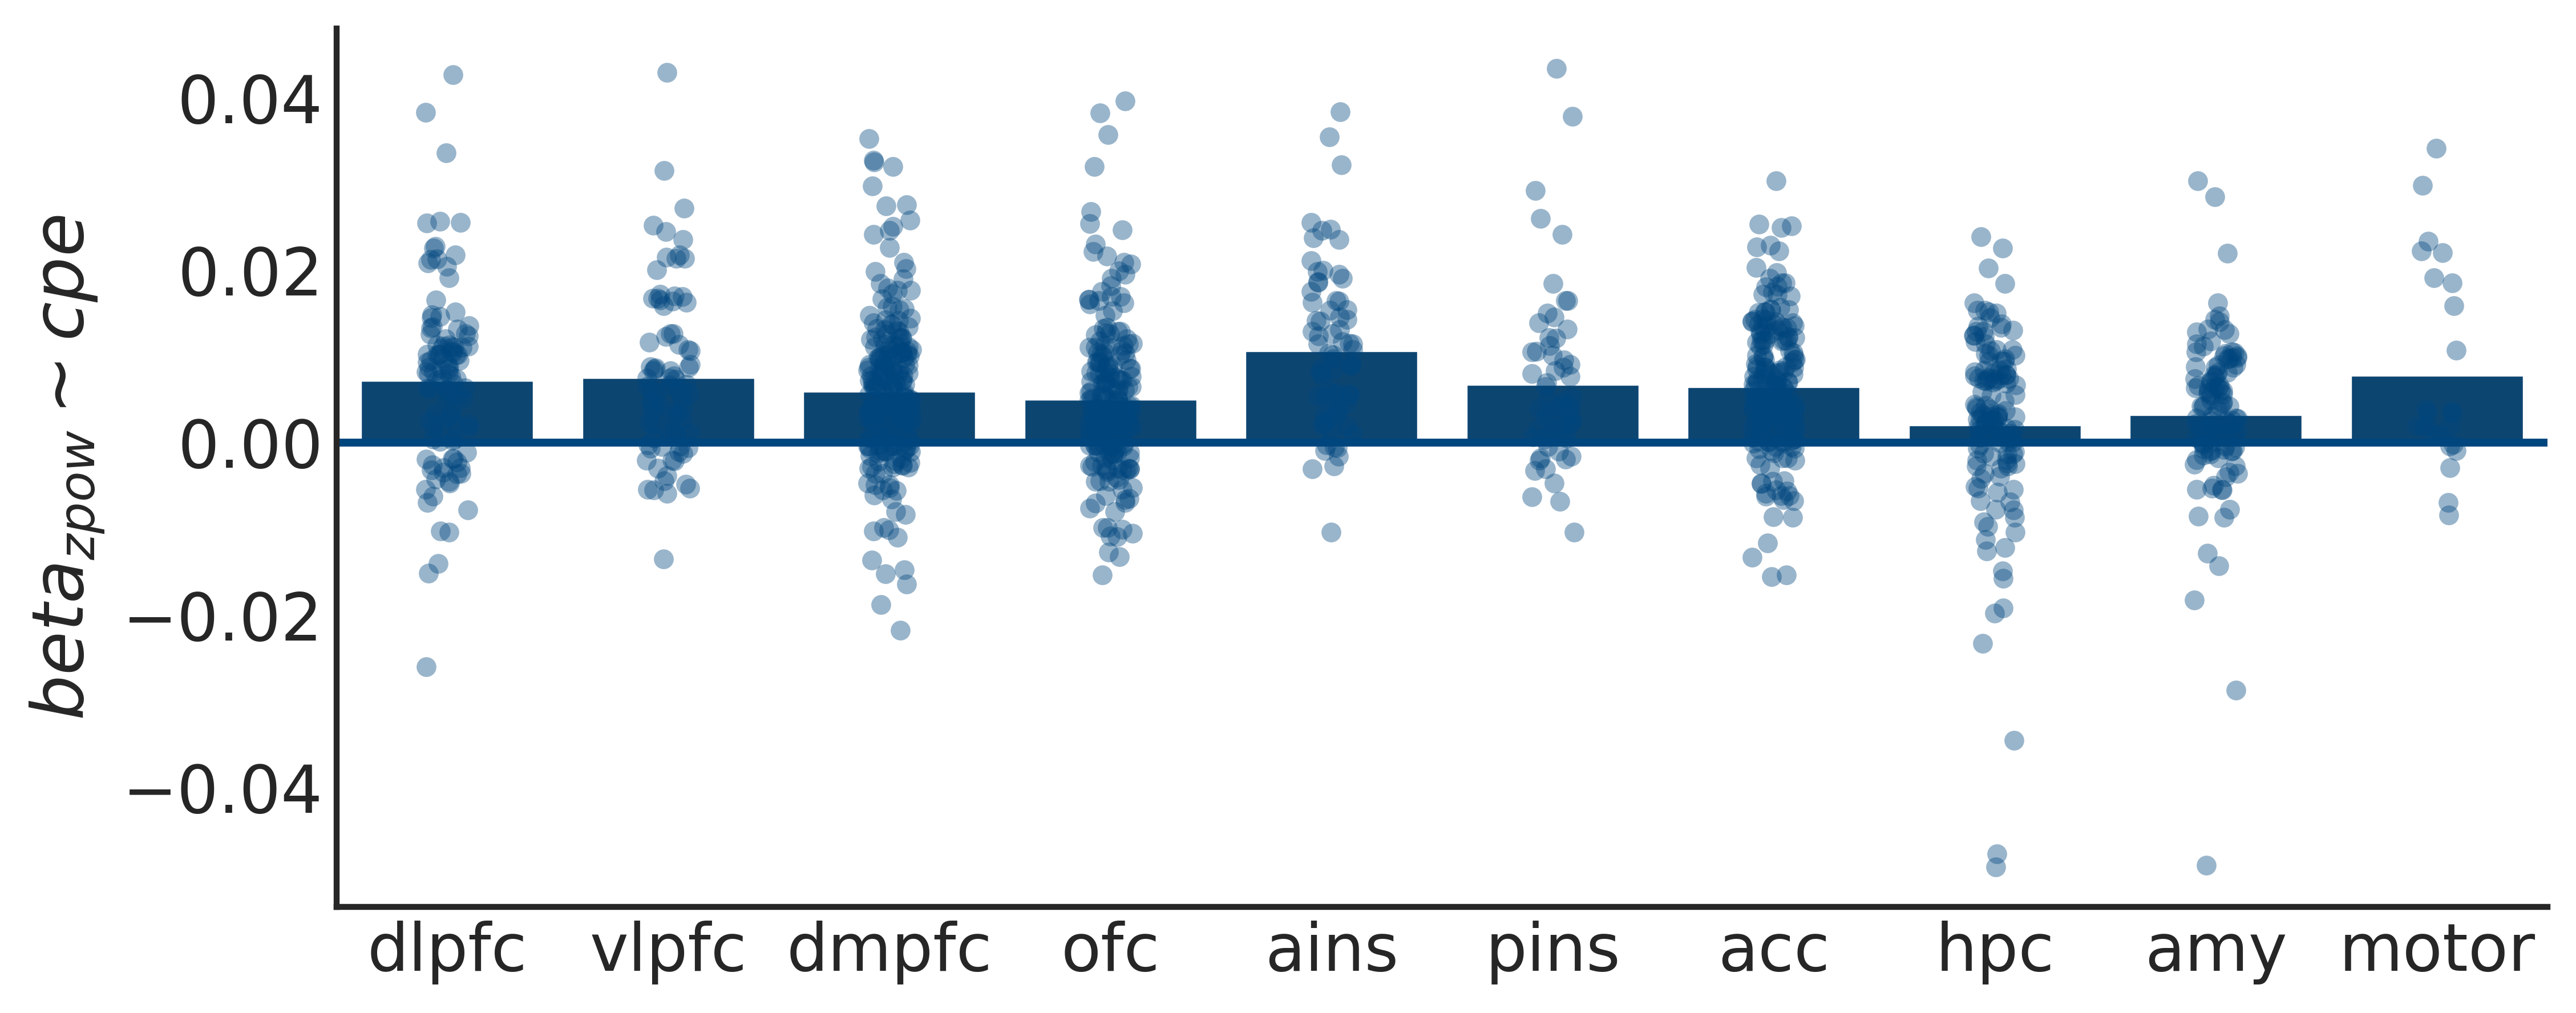

In [24]:
y_var     = 'decisionCPE'
x_var     = 'roi'
ylabel    = r'$beta_{{{zpow}}} \sim cpe$'
color     = '#00467e'
save_dir  = f'{base_dir}ephys_analysis/results/regression_data/'
fig_id    = 'MLM_Bpow_CPE_barplot.pdf'

plot_roi_model_results(model_results,x_var,y_var,ylabel,color,bar_order,sns_context="talk",size=5,figsize=(10,4),
                      save_fig=True,save_dir=save_dir,fig_id=fig_id)

# plot_roi_model_results(model_results,x_var,y_var,ylabel,color,bar_order,figsize=(18,6),save_fig=True,
#                       save_dir=save_dir,fig_id=fig_id)
# model_results,x_var,y_var,ylabel,color,bar_order,figsize=(10,4),dpi=500,
#                            sns_context="poster",save_fig=False,save_dir=None,fig_id=None)

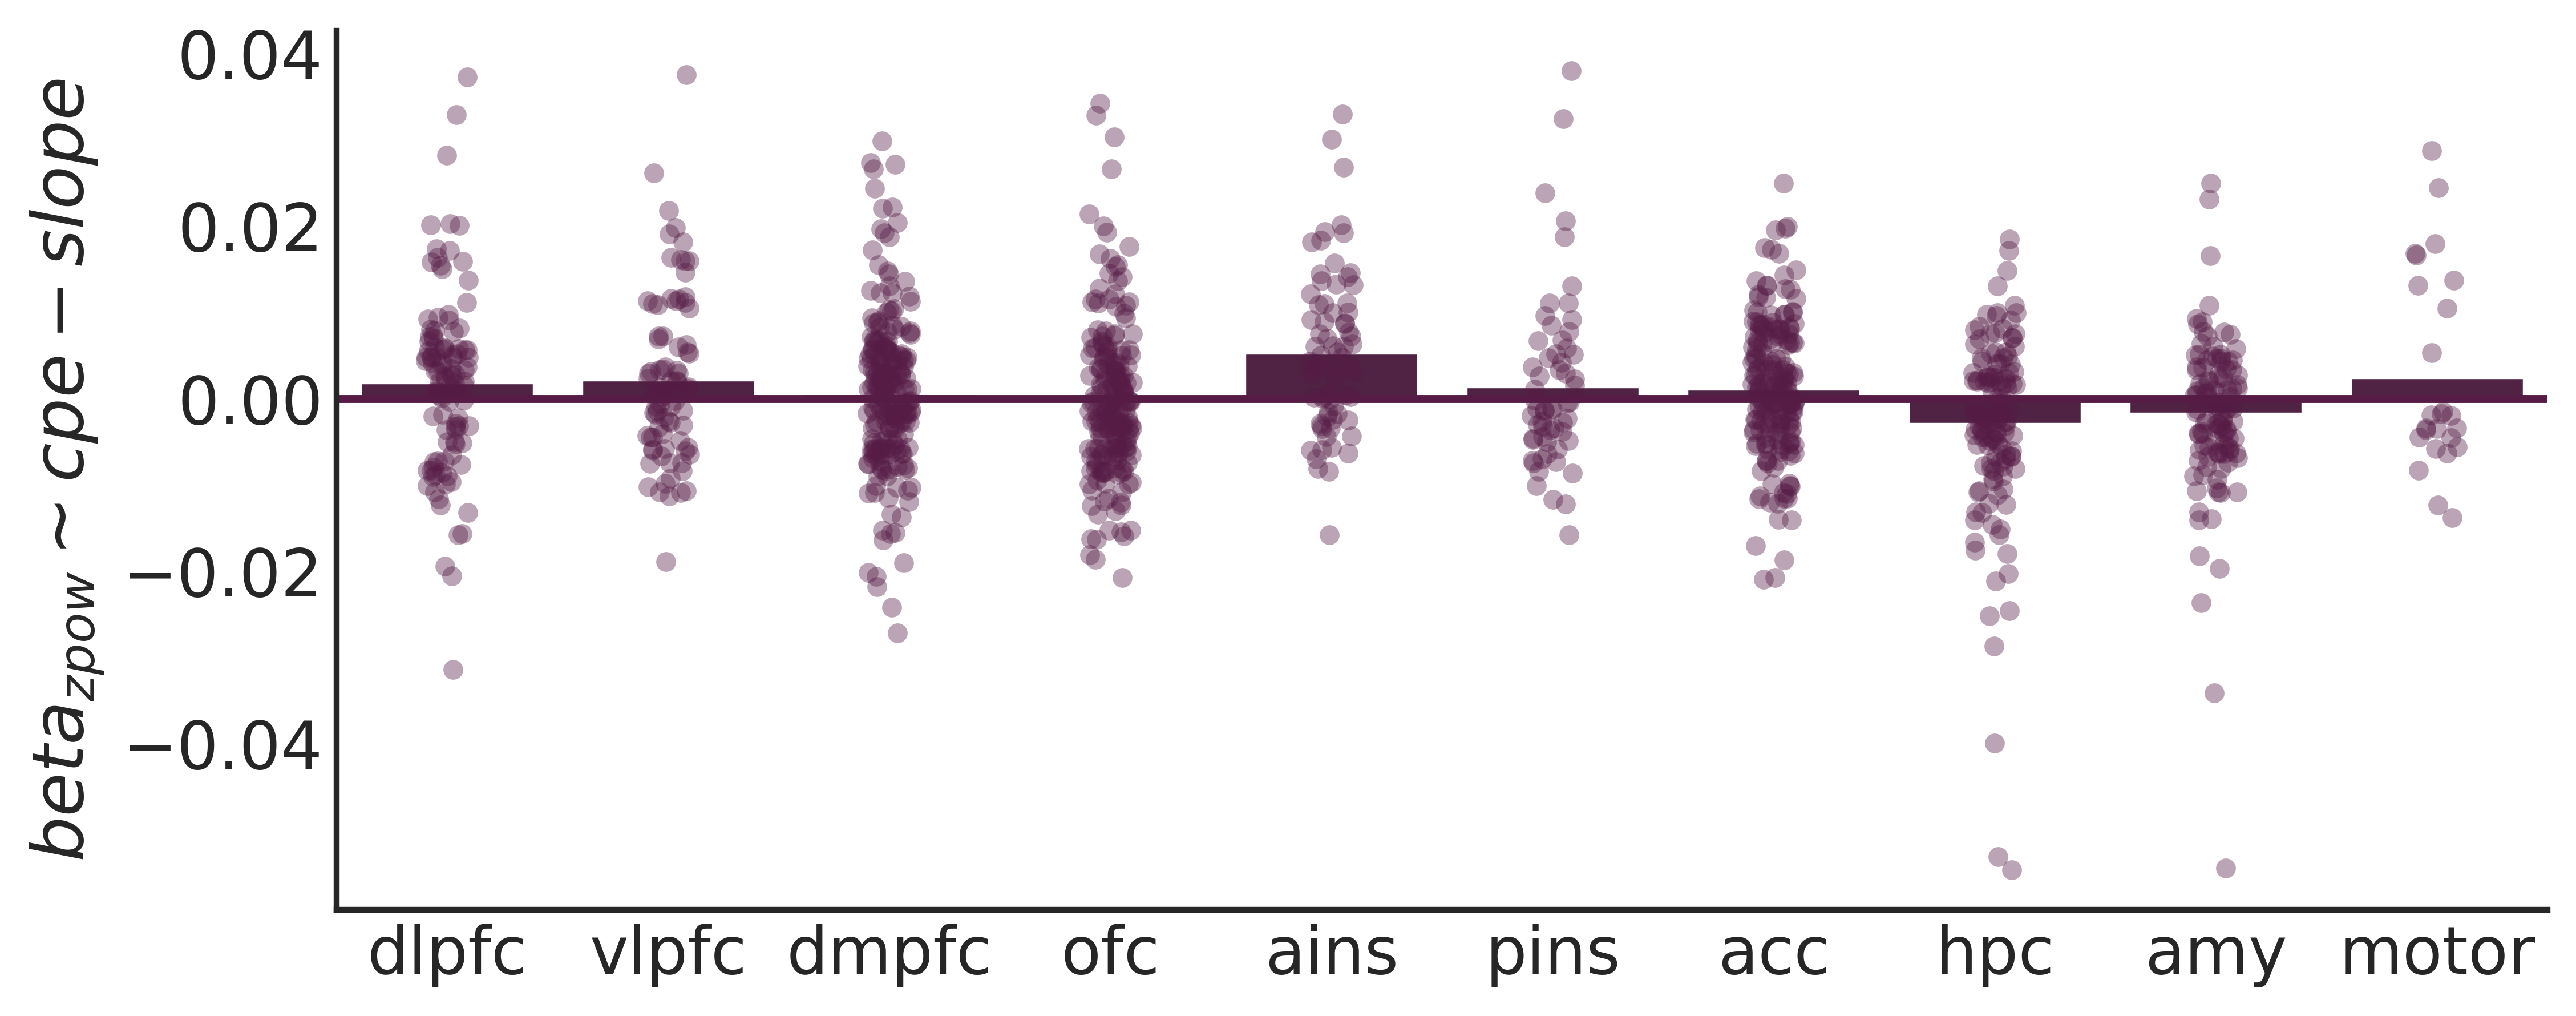

In [25]:
y_var     = 'raw_decisionCPE'
x_var     = 'roi'
ylabel    = r'$beta_{{{zpow}}} \sim cpe-slope$'
color     = '#561c46'
save_dir  = f'{base_dir}ephys_analysis/results/regression_data/'
fig_id    = 'MLM_Bpow_rawCPE_barplot.pdf'

# plot_roi_model_results(model_results,x_var,y_var,ylabel,color,bar_order,sns_context="talk",size=5,figsize=(10,4))

plot_roi_model_results(model_results,x_var,y_var,ylabel,color,bar_order,sns_context="talk",size=5,figsize=(10,4),
                      save_fig=True,save_dir=save_dir,fig_id=fig_id)

# plot_roi_model_results(model_results,x_var,y_var,ylabel,color,bar_order,figsize=(18,6),save_fig=True,
#                       save_dir=save_dir,fig_id=fig_id)
# model_results,x_var,y_var,ylabel,color,bar_order,figsize=(10,4),dpi=500,
#                            sns_context="poster",save_fig=False,save_dir=None,fig_id=None)

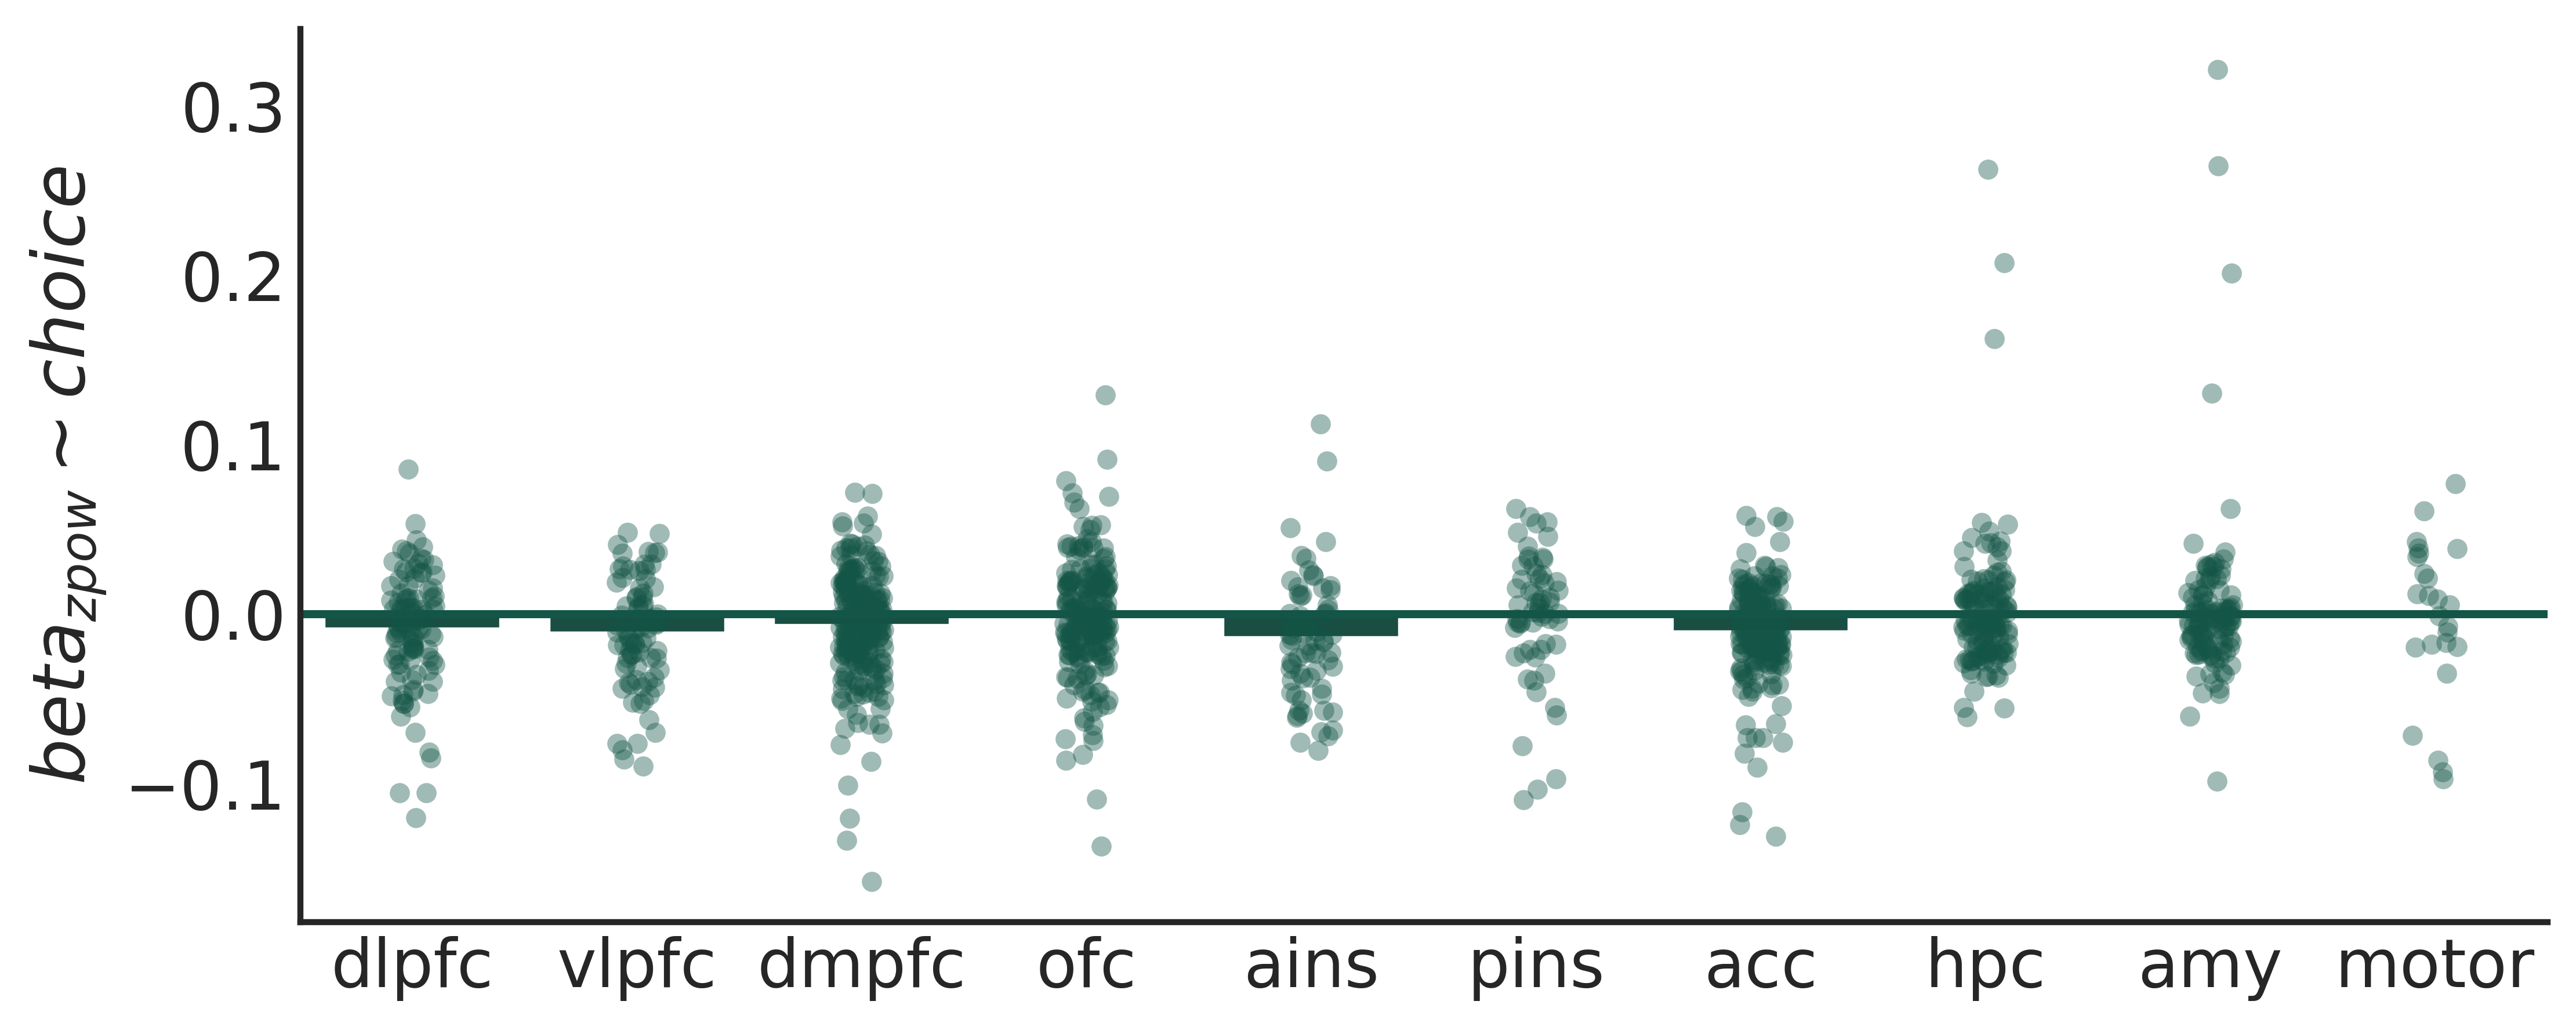

In [30]:
y_var     = 'GambleChoice'
x_var     = 'roi'
ylabel    = r'$beta_{{{zpow}}} \sim choice$'
color     = '#135546'
save_dir  = f'{base_dir}ephys_analysis/results/regression_data/'
fig_id    = 'MLM_Bpow_choice_barplot.pdf'

# plot_roi_model_results(model_results,x_var,y_var,ylabel,color,bar_order,sns_context="talk",size=5,figsize=(10,4))

plot_roi_model_results(model_results,x_var,y_var,ylabel,color,bar_order,sns_context="talk",size=5,figsize=(10,4),
                      save_fig=True,save_dir=save_dir,fig_id=fig_id)

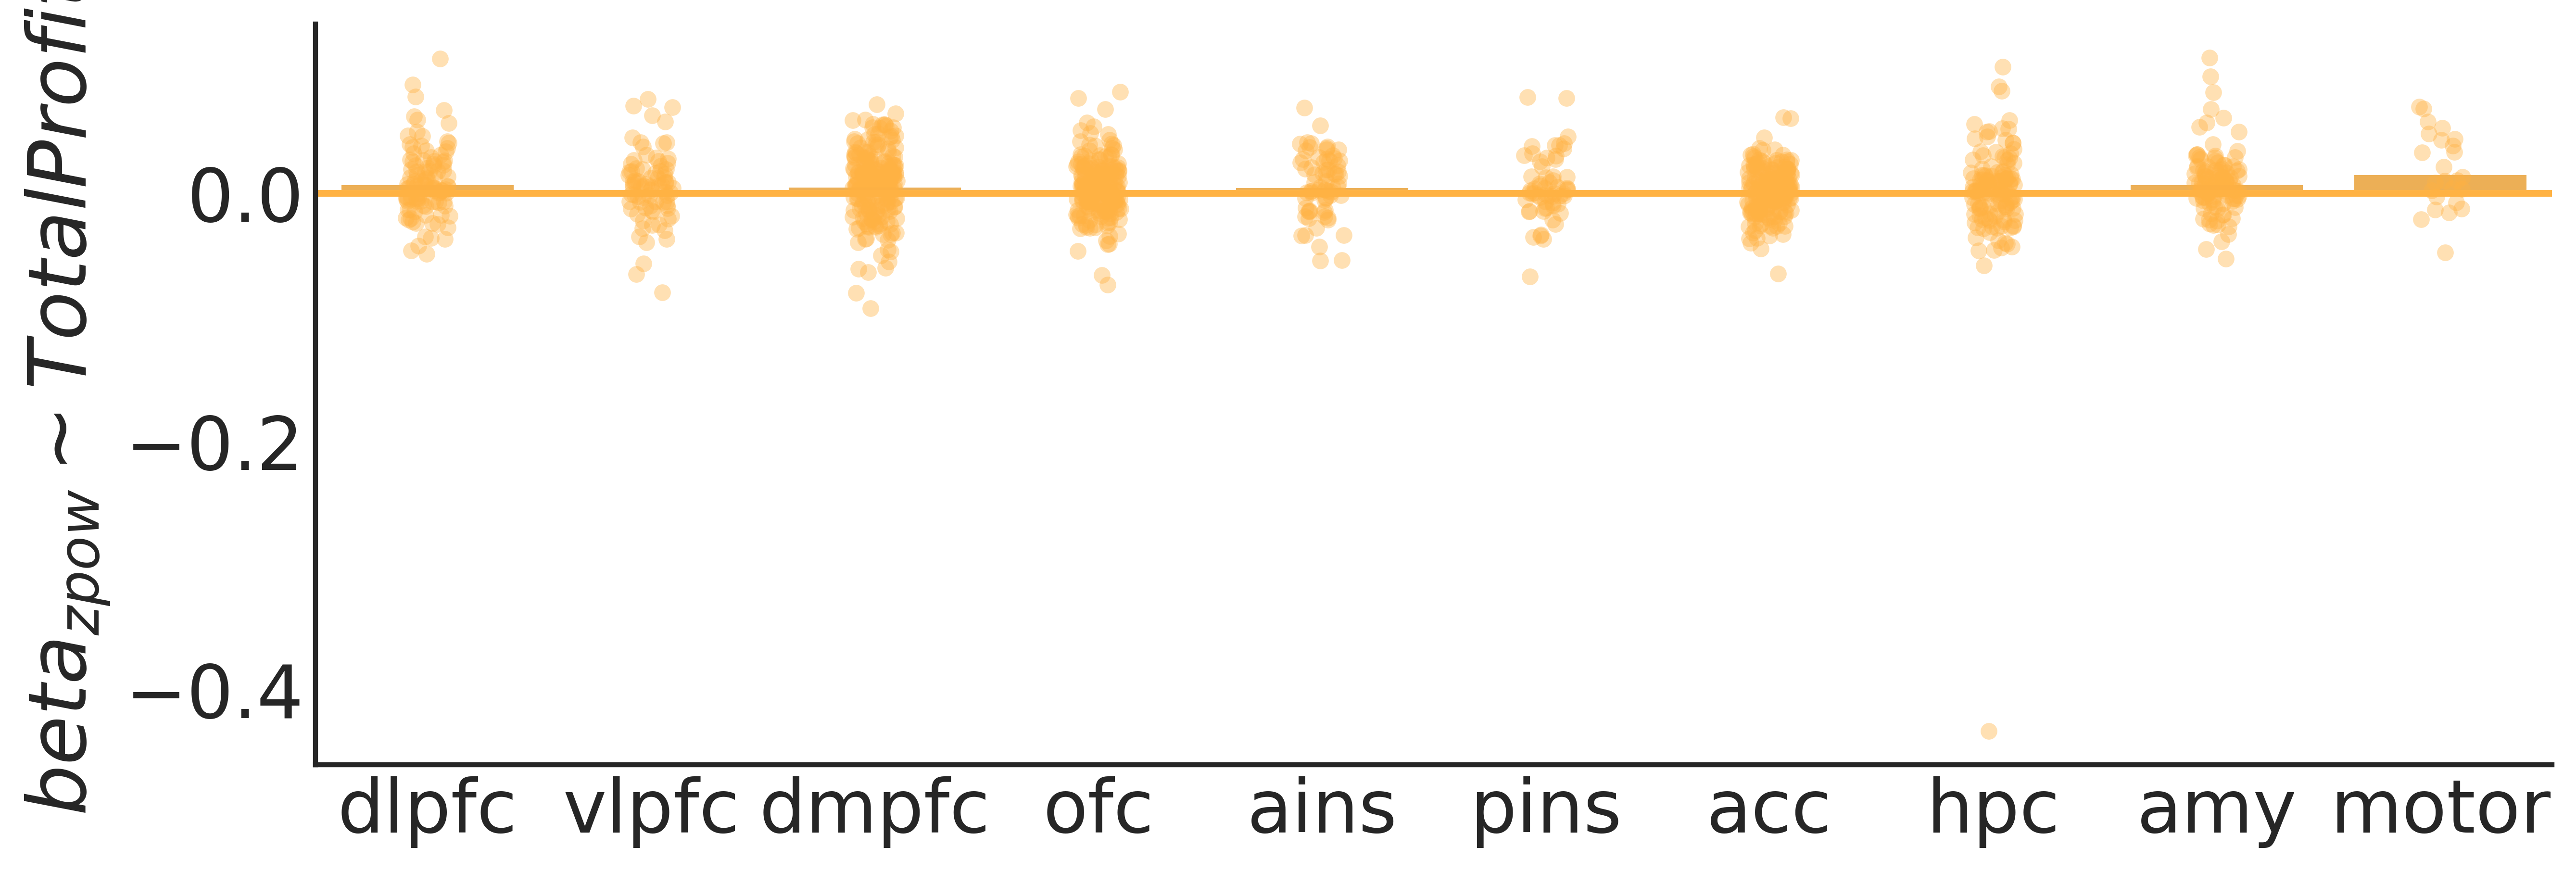

In [31]:
y_var     = 'TotalProfit'
x_var     = 'roi'
ylabel    = r'$beta_{{{zpow}}} \sim Total Profit$'
color     = '#ffb243'
save_dir  = f'{base_dir}ephys_analysis/results/regression_data/'
fig_id    = 'MLM_Bpow_TotalProfit_barplot.pdf'

# plot_roi_model_results(model_results,x_var,y_var,ylabel,color,bar_order,sns_context="talk",size=5,figsize=(10,4))

plot_roi_model_results(model_results,x_var,y_var,ylabel,color,bar_order,sns_context="poster",size=5,figsize=(12,4),
                      save_fig=True,save_dir=save_dir,fig_id=fig_id)


In [32]:
# ##### simple stats
# ['#ffb243',
#  '#fdcd63',
#  '#ecda77',
#  '#9bb060',
#  '#598a49',
#  '#2e6a33',
#  '#135546',
#  '#034975',
#  '#263365',
#  '#561c46']


In [31]:
raw_roi_stats = {f'{roi}':ttest_1samp(model_results.raw_decisionCPE[model_results.roi == roi].unique(),
                 popmean=0) for roi in model_results.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=2.3048392494415872, pvalue=0.02224494287116745, df=192),
 'dmpfc': TtestResult(statistic=1.278840539831762, pvalue=0.2023318320700994, df=215),
 'hpc': TtestResult(statistic=-3.375061632421039, pvalue=0.000965680856988553, df=134),
 'sts': TtestResult(statistic=-0.1703862417712533, pvalue=0.8649300346016296, df=154),
 'amy': TtestResult(statistic=-2.2295629238749606, pvalue=0.02777128632686372, df=112),
 'parietal': TtestResult(statistic=0.0483437886454234, pvalue=0.9618596083594911, df=23),
 'stg': TtestResult(statistic=-2.547570111145431, pvalue=0.012310353609556488, df=104),
 'mcc': TtestResult(statistic=-1.9348204170363035, pvalue=0.06355312147766926, df=27),
 'mtg': TtestResult(statistic=-1.5580318292984956, pvalue=0.12485971196039793, df=56),
 'smg': TtestResult(statistic=-1.8669642072365862, pvalue=0.06641753908234624, df=65),
 'phg': TtestResult(statistic=-3.0229238658100552, pvalue=0.005876396573308688, df=24),
 'temporal pole': TtestResult(statis

In [32]:
roi_stats = {f'{roi}':ttest_1samp(model_results.decisionCPE[model_results.roi == roi].unique(),
                 popmean=0) for roi in model_results.roi.unique().tolist()}
roi_stats

{'acc': TtestResult(statistic=11.930614115484516, pvalue=6.562643043986769e-25, df=192),
 'dmpfc': TtestResult(statistic=9.974688919798385, pvalue=1.6774242953121619e-19, df=215),
 'hpc': TtestResult(statistic=2.3772768537635613, pvalue=0.018854357764090373, df=134),
 'sts': TtestResult(statistic=5.770556251020745, pvalue=4.210039678173822e-08, df=154),
 'amy': TtestResult(statistic=3.8830236003572307, pvalue=0.00017488138685364907, df=112),
 'parietal': TtestResult(statistic=3.811346394359426, pvalue=0.0008976897010532713, df=23),
 'stg': TtestResult(statistic=3.9117334201838245, pvalue=0.0001636898162587382, df=104),
 'mcc': TtestResult(statistic=0.6196733094251257, pvalue=0.5406675327933057, df=27),
 'mtg': TtestResult(statistic=1.7594123899299485, pvalue=0.08396959363364481, df=56),
 'smg': TtestResult(statistic=3.1120155712371775, pvalue=0.002760611986189085, df=65),
 'phg': TtestResult(statistic=1.4487718220220256, pvalue=0.1603419327315553, df=24),
 'temporal pole': TtestResult(

In [33]:
pairwise_ains_vals = model_results.decisionCPE[model_results.roi == 'ains'].unique()

pairwise_roi_stats = {f'ains={roi}':ttest_ind(pairwise_ains_vals,
                                              model_results.decisionCPE[model_results.roi == roi].unique(),
                 ) for roi in model_results.roi.unique().tolist()}
pairwise_roi_stats


{'ains=acc': TtestResult(statistic=3.6517996380143196, pvalue=0.0003143907145988106, df=262.0),
 'ains=dmpfc': TtestResult(statistic=3.7214910651794457, pvalue=0.00023857643459467595, df=285.0),
 'ains=hpc': TtestResult(statistic=5.6656294269309, pvalue=4.943059028947941e-08, df=204.0),
 'ains=sts': TtestResult(statistic=3.6536568585801454, pvalue=0.0003220140193495417, df=224.0),
 'ains=amy': TtestResult(statistic=5.2395197305266255, pvalue=4.4239075737645524e-07, df=182.0),
 'ains=parietal': TtestResult(statistic=2.5894040948691095, pvalue=0.011158999274401222, df=93.0),
 'ains=stg': TtestResult(statistic=5.563392551029464, pvalue=9.835081414188672e-08, df=174.0),
 'ains=mcc': TtestResult(statistic=4.329638561962695, pvalue=3.637679241083523e-05, df=97.0),
 'ains=mtg': TtestResult(statistic=4.185105189208136, pvalue=5.305462152593316e-05, df=126.0),
 'ains=smg': TtestResult(statistic=4.819639712023269, pvalue=3.8152296537671215e-06, df=135.0),
 'ains=phg': TtestResult(statistic=4.547

In [34]:
pairwise_ains_vals = model_results.decisionCPE[model_results.roi == 'ains'].unique()

pairwise_roi_stats_greater = {f'ains={roi}':ttest_ind(pairwise_ains_vals,
                                              model_results.decisionCPE[model_results.roi == roi].unique(),
                 alternative='greater') for roi in model_results.roi.unique().tolist()}
pairwise_roi_stats_greater

{'ains=acc': TtestResult(statistic=3.6517996380143196, pvalue=0.0001571953572994053, df=262.0),
 'ains=dmpfc': TtestResult(statistic=3.7214910651794457, pvalue=0.00011928821729733797, df=285.0),
 'ains=hpc': TtestResult(statistic=5.6656294269309, pvalue=2.4715295144739704e-08, df=204.0),
 'ains=sts': TtestResult(statistic=3.6536568585801454, pvalue=0.00016100700967477084, df=224.0),
 'ains=amy': TtestResult(statistic=5.2395197305266255, pvalue=2.2119537868822762e-07, df=182.0),
 'ains=parietal': TtestResult(statistic=2.5894040948691095, pvalue=0.005579499637200611, df=93.0),
 'ains=stg': TtestResult(statistic=5.563392551029464, pvalue=4.917540707094336e-08, df=174.0),
 'ains=mcc': TtestResult(statistic=4.329638561962695, pvalue=1.8188396205417615e-05, df=97.0),
 'ains=mtg': TtestResult(statistic=4.185105189208136, pvalue=2.652731076296658e-05, df=126.0),
 'ains=smg': TtestResult(statistic=4.819639712023269, pvalue=1.9076148268835608e-06, df=135.0),
 'ains=phg': TtestResult(statistic=4.

In [35]:
pairwise_ains_vals = model_results.decisionCPE[model_results.roi == 'ains'].unique()

pairwise_roi_stats_less = {f'ains={roi}':ttest_ind(pairwise_ains_vals,
                                              model_results.decisionCPE[model_results.roi == roi].unique(),
                 alternative='less') for roi in model_results.roi.unique().tolist()}
pairwise_roi_stats_less

{'ains=acc': TtestResult(statistic=3.6517996380143196, pvalue=0.9998428046427006, df=262.0),
 'ains=dmpfc': TtestResult(statistic=3.7214910651794457, pvalue=0.9998807117827027, df=285.0),
 'ains=hpc': TtestResult(statistic=5.6656294269309, pvalue=0.9999999752847049, df=204.0),
 'ains=sts': TtestResult(statistic=3.6536568585801454, pvalue=0.9998389929903252, df=224.0),
 'ains=amy': TtestResult(statistic=5.2395197305266255, pvalue=0.9999997788046213, df=182.0),
 'ains=parietal': TtestResult(statistic=2.5894040948691095, pvalue=0.9944205003627994, df=93.0),
 'ains=stg': TtestResult(statistic=5.563392551029464, pvalue=0.9999999508245929, df=174.0),
 'ains=mcc': TtestResult(statistic=4.329638561962695, pvalue=0.9999818116037946, df=97.0),
 'ains=mtg': TtestResult(statistic=4.185105189208136, pvalue=0.999973472689237, df=126.0),
 'ains=smg': TtestResult(statistic=4.819639712023269, pvalue=0.9999980923851731, df=135.0),
 'ains=phg': TtestResult(statistic=4.547035314768043, pvalue=0.9999919000

In [33]:
# rho_data = []
# sig_rho = []

# # bonferr_alpha = 0.05/len(roi_plot_data.roi.unique().tolist())
# # bonferr_alpha = 0.05/9
# bonferr_alpha = 0.01

# # BDI CORRELATIONS
# for roi in roi_plot_data.roi.unique().tolist()[:]:
#     roi_temp_data = roi_plot_data[roi_plot_data.roi==roi]
#     rho,rho_p     = spearmanr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
# #     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
# #     print(f'{roi} pearsonr',rho,rho_p)
#     rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
# #     if rho_p <= bonferr_alpha:
# #         sig_bdi_rois.append(roi)
# #     if rho_p < bonferr_alpha:
#     if rho_p < 0.05:
#         sig_rho.append((roi,rho,rho_p))
#     print(f'{roi} pearsonr',rho,rho_p)
# rho_data = pd.concat(rho_data).reset_index(drop=True)


In [34]:
# rho_data['round_rho'] = np.round(rho_data.rho,2)
# rho_data['round_p']   = np.round(rho_data.rho_p,2)
# rho_data['round_p'][rho_data.roi == 'acc'] = 0.01
# rho_data['round_p'][rho_data.roi == 'ofc'] = 0.01
# rho_data

In [35]:

# sns.set_context("talk",rc={'axes.linewidth': 1.5})

# for roi in roi_plot_data.roi.unique().tolist()[:-1]:
#     roi_temp_data = roi_plot_data[roi_plot_data.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
#     fig,ax = plt.subplots(1,1,figsize=(5,3.5),dpi=300)

#     sns.regplot(data=roi_temp_data,x='bdi',y='elec_bCPE',scatter=False,ci=95,
#                 fit_reg=True,color = '#00467e') #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='raw_decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
# #     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
#     plt.xlabel('BDI-II')
# #     plt.xlim([0,40])
    
#     plt.tick_params(length=0) 
# #     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(r'$beta_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
# #              color='#00467e',fontsize=16)
# #     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
# #             verticalalignment='top', horizontalalignment='right',
# #             color='k',fontsize=16)

#     plt.title(f'{roi}',fontsize=20)
#     plt.tight_layout()


    
#     sns.despine()
    
#     plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
#         bbox_inches='tight', pad_inches=0.1,dpi=300,
#         facecolor='auto', edgecolor='auto',
#         backend=None)
    

# INDIVIDUAL ROI MODELS

In [36]:
test_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy','motor']


In [37]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
final_vars   = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE']

In [40]:
roi_fit_dict = {f'{roi}':fit_mixed_model(band_reg_df[band_reg_df.roi==roi],
                                        final_vars,outcome_var,rand_eff_var,reml=False) for roi in test_rois}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],band_reg_df[band_reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)



In [42]:
len(roi_fit_results)

1204

In [45]:
bonferr_alpha = 0.05/len(test_rois)

In [46]:
sig_roi_fit_results = roi_fit_results[roi_fit_results.decisionCPE <= bonferr_alpha]

In [49]:
sig_roi_fit_results.roi.value_counts()

ofc      97
dmpfc    97
amy      84
acc      80
hpc      69
dlpfc    41
vlpfc    22
pins      9
motor     8
ains      6
Name: roi, dtype: int64

# INTERACTION FEATURE SELECTION